In [55]:
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from transformers import pipeline
import matplotlib.pyplot as plt

In [56]:
valid_animals = {
    "CHICKEN", "DOG", "CAT", "COW", "HORSE",
    "ELEPHANT", "SPIDER", "SHEEP", "SQUIRREL", "BUTTERFLY"
}

class_names = [
    "butterfly",
    "cat",
    "chicken",
    "cow",
    "dog",
    "elephant",
    "horse",
    "sheep",
    "spider",
    "squirrel"
  ]

In [57]:
cnn_model_path = "./image_classification_model/animal_cnn_model/animal_cnn.pth"
ner_model_path = "./ner model/animal_ner_model"
image_path = "./prince.jpg"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text = "dog and cats"

In [58]:
class AnimalCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AnimalCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(256)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1   = nn.Linear(256 * 16 * 16, 512)
        self.fc2   = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [59]:
def preprocess_image(image_path, image_size):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)
    return image

def load_image_model(model_path, num_classes, device):
    model = AnimalCNN(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def classify_image(model, image_tensor, class_names, device):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = F.softmax(outputs[0], dim=0)
        predicted_idx = torch.argmax(probs).item()
    return class_names[predicted_idx] if class_names else str(predicted_idx)


def ner_cnn_pipeline(ner_path, cnn_path, text, image_path):
  ner_pipeline = pipeline(
    "token-classification",
    model=ner_path,
    tokenizer=ner_path,
    aggregation_strategy="simple"
  )
  print("Input Text:")
  print(text)
  print("\n")


  img = Image.open(image_path)
  plt.imshow(img)
  plt.title("Input Image")
  plt.axis("off")
  plt.show()

  predictions = ner_pipeline(text)
  found_animals = False

  for entity in predictions:
      label = entity.get("entity_group", "").upper()
      token = entity.get("word", "")
      if label in valid_animals:
          print(f"Token: '{token}', Label: {label}")
          found_animals = True
          animal_from_text = label

  if not found_animals:
      print("No animals recognized.")

  image_tensor = preprocess_image(image_path, 128)
  image_model = load_image_model(cnn_path, num_classes=len(class_names), device=device)

  animal_from_image = classify_image(image_model, image_tensor, class_names, device)
  print(f"Animal found in image: {animal_from_image}")

  if animal_from_text.lower() == animal_from_image.lower():
      print("1")
  else:
      print("0")

Input Text:
dog and cats




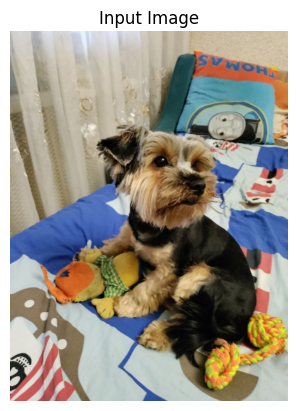

Token: 'dog', Label: DOG
Animal found in image: dog
1


/tmp/ipykernel_7156/319815301.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [60]:
ner_cnn_pipeline(ner_model_path, cnn_model_path, text, image_path)

In [61]:
image_path = "./kit.jpg"

Input Text:
dog and cats




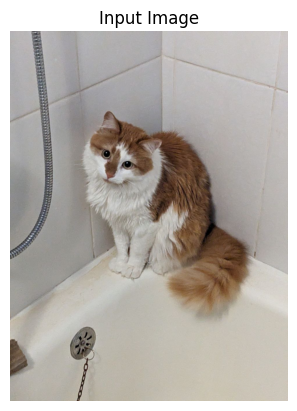

Token: 'dog', Label: DOG
Animal found in image: cat
0


/tmp/ipykernel_7156/319815301.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [62]:
ner_cnn_pipeline(ner_model_path, cnn_model_path, text, image_path)


In [63]:
image_path = "./dzhek-rassel-terer.jpg"

Input Text:
dog and cats




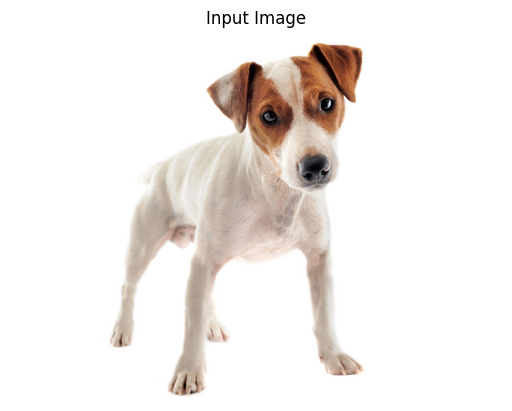

Token: 'dog', Label: DOG


/tmp/ipykernel_7156/319815301.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Animal found in image: dog
1


In [64]:
ner_cnn_pipeline(ner_model_path, cnn_model_path, text, image_path)
